In [ ]:
import os
import librosa

base_dir = os.path.dirname(os.path.abspath(''))

# Queen Data

In [ ]:
queen = os.path.join(base_dir, 'data/queen_presence/queen/Hive1_12_06_2018_QueenBee_H1_audio___16_00_00-bee-14-18.wav')
queen_2 = os.path.join(base_dir, 'data/queen_presence/queen/CF003 - Active - Day - (214)-bee-1-2.wav')
queen_3 = os.path.join(base_dir, 'data/queen_presence/queen/GH001 - Active - Day - 141022_0659_0751-bee-25-1.wav')
queen_4 = os.path.join(base_dir, 'data/queen_presence/queen/Hive3_20_07_2017_QueenBee_H3_audio___06_20_00-bee-1-1.wav')

no_queen = os.path.join(base_dir, 'data/queen_presence/no_queen/CJ001 - Missing Queen - Day - (101)-bee-1-6.wav')
no_queen_2 = os.path.join(base_dir, 'data/queen_presence/no_queen/Hive3_12_07_2017_NO_QueenBee_H3_audio___15_40_00-bee-1-106.wav')
no_queen_3 = os.path.join(base_dir, 'data/queen_presence/no_queen/CF001 - Missing Queen - Day --bee-1-3.wav')
no_queen_4 = os.path.join(base_dir, 'data/queen_presence/no_queen/Hive1_31_05_2018_NO_QueenBee_H1_audio___15_40_00-bee-62-9.wav')

signal, _ = librosa.load(queen)

# Play recordings

# AutoEncoder

In [112]:
import torch
import torch.nn as nn
import numpy as np
import re
import librosa
import librosa.display
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger

from datasets.audio_dataset import AudioDataset

import os

class AudioAutoencoder(pl.LightningModule):
    def __init__(self, feature_type='mel', sample_rate=22050, duration=1, n_fft=2048, hop_length=512, n_mels=128, learning_rate=0.001):
        super().__init__()
        self.feature_type = feature_type
        self.sample_rate = sample_rate
        self.duration = duration
        self.n_fft = n_fft
        self.hop_length = hop_length
        self.n_mels = n_mels
        self.learning_rate = learning_rate

        # Calculate the size of the input
        
        if self.feature_type == 'mel':
            self.input_height = self.n_mels
        elif self.feature_type == 'stft':
            self.input_height = self.n_fft // 2 + 1
        else:
            raise ValueError("feature_type must be either 'mel' or 'stft'")

        self.input_width = (self.sample_rate * self.duration) // self.hop_length + 1
        print(f"INPUT WIDTH: {self.input_width} INPUT HEIGHT: {self.input_height}")
        # 
        # Calculate the size after convolutions
        self.conv_output_width = self._calculate_output_size(self.input_width, kernel=3, stride=2, padding=1, num_convs=3)
        self.conv_output_height = self._calculate_output_size(self.input_height, kernel=3, stride=2, padding=1, num_convs=3)
        self.conv_output_size = 64 * self.conv_output_height * self.conv_output_width
        print(f"CONV OUTPUT WIDTH: {self.conv_output_width} CONV OUTPUT HEIGHT: {self.conv_output_height} CONV OUTPUT SIZE: {self.conv_output_size}")

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(self.conv_output_size, 128),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(128, self.conv_output_size),
            nn.ReLU(),
            nn.Unflatten(1, (64, self.conv_output_height, self.conv_output_width)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )
        
        self.final_conv = nn.Conv2d(1, 1, kernel_size=3, padding=1,)
        
    def _calculate_output_size(self, input_size, kernel, stride, padding, num_convs):
        # Base case: If there are no more convolutions, return the input size
        if num_convs == 0:
            return input_size
        else:
            # Apply the convolution formula
            output_size = (input_size - kernel + 2 * padding) // stride + 1
            # Recursive call for the next convolution layer
            return self._calculate_output_size(output_size, kernel, stride, padding, num_convs - 1)
 

    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        encoded = self.encoder(x.unsqueeze(1))
        # print(f"After encoder shape: {encoded.shape}")
        decoded = self.decoder(encoded)
        # print(f"After decoder shape: {decoded.shape}")
        if decoded.shape[-2:] != (self.input_height, self.input_width):
            decoded = nn.functional.interpolate(decoded, size=(self.input_height, self.input_width), mode='bilinear', align_corners=False)
            print(f"Final output shape: {decoded.shape}")
        return decoded.squeeze(1)

    def training_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, _ = batch
        x_hat = self(x)
        loss = nn.functional.mse_loss(x_hat, x)
        self.log('val_loss', loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer
    
    def on_train_start(self):
        # Log the input shape for debugging
        self.logger.experiment.add_text('input_shape', f'{self.input_height}x{self.input_width}')
        self.logger.experiment.add_text('conv_output_size', f'{self.conv_output_size}')

def detect_anomalies(model, test_loader, threshold, device):
    model.eval()
    anomalies = []
    mse_values = []
    reconstructions = []
    originals = []
    file_paths = []

    with torch.no_grad():
        for batch, paths in test_loader:
            batch = batch.to(device)
            outputs = model(batch)
            mse = nn.functional.mse_loss(outputs, batch, reduction='none').mean(dim=(1,2))
            anomalies.extend((mse > threshold).cpu().numpy())
            reconstructions.extend(outputs.cpu().numpy())
            originals.extend(batch.cpu().numpy())
            mse_values.extend(mse.detach().cpu().numpy())
            file_paths.extend(paths)

    return np.array(anomalies), np.array(reconstructions), np.array(originals), file_paths, mse_values


def plot_spectrogram(path, hop_length, title=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
    else:
        fig = ax.figure
    
    signal, sr = librosa.load(path)
    stft_matrix = librosa.stft(
    signal, n_fft=N_FFT, hop_length=hop_length
)
    spec = np.abs(stft_matrix)
    specDB = librosa.amplitude_to_db(spec, ref=np.max)

    img = librosa.display.specshow(
        specDB,
        sr=sr,
        hop_length=hop_length,
        x_axis="time",
        y_axis="mel",
        ax=ax,
        cmap='magma',
    )
    fig.colorbar(img, ax=ax, format="%+2.0f dB")
    ax.set_title(f"Spectrogram of {title}" if title is not None else "Spectrogram")
    return fig

def plot_anomalies(anomalies, reconstructions, originals, file_paths, mses):
    for i, (is_anomaly, reconstruction, original, file_path, mse) in enumerate(zip(anomalies, reconstructions, originals, file_paths, mses)):
        if is_anomaly:
            fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
            # Regular expression to match the phrases
            pattern = r"(QueenBee|Missing Queen|NO_QueenBee)"
            
            # Search for matches in the file name
            match = re.search(pattern, file_path)
            plot_spectrogram(file_path, HOP_LENGTH, title=f"Original | {match.group(0)} |  MSE {mse:.4f}", ax=ax1)

            plt.tight_layout()
            plt.show()
            

def plot_reference(anomalies, reconstructions, originals, file_paths, mses):
        
        first_non_anomaly = next((
            (reconstruction, original, file_path, mse)
            for is_anomaly, reconstruction, original, file_path, mse 
            in zip(anomalies, reconstructions, originals, file_paths, mses)
            if not is_anomaly
        ), None)

        if first_non_anomaly:
            reconstruction, original, file_path, mse = first_non_anomaly
            
            fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))
            
            # Regular expression to match the phrases
            pattern = r"(QueenBee|Missing Queen|NO_QueenBee)"
            
            # Search for matches in the file name
            match = re.search(pattern, file_path)
            
            if match:
                title = f"Original | {match.group(0)} | MSE {mse:.4f}"
            else:
                title = f"Original | MSE {mse:.4f}"
            
            plot_spectrogram(file_path, HOP_LENGTH, title=title, ax=ax1)

            plt.tight_layout()
            plt.show()


In [119]:

FEATURE_TYPE = 'stft'
# Other parameters
SAMPLE_RATE = 22050
DURATION = 1
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 128 if FEATURE_TYPE == 'mel' else None
LEARNING_RATE = 0.001

# Usage example
base_dir = os.path.dirname(os.path.abspath(''))

training_files = os.listdir(os.path.join(base_dir,"data/aric_showcase/train"))
testing_files = os.listdir(os.path.join(base_dir,"data/aric_showcase/test2"))

train_file_paths = [os.path.join(base_dir, 'data/aric_showcase/train', file) for file in training_files]
val_file_paths = train_file_paths[:100]
train_file_paths = train_file_paths[100:]
test_file_paths = [os.path.join(base_dir, 'data/aric_showcase/test2', file) for file in testing_files]

 # Assume we have lists of file paths for training and testing
train_dataset = AudioDataset(train_file_paths, feature_type=FEATURE_TYPE, sample_rate=SAMPLE_RATE,
                                 duration=DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
val_dataset = AudioDataset(val_file_paths, feature_type=FEATURE_TYPE, sample_rate=SAMPLE_RATE,
                           duration=DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)
test_dataset = AudioDataset(test_file_paths, feature_type=FEATURE_TYPE, sample_rate=SAMPLE_RATE,
                            duration=DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=0)

model = AudioAutoencoder(feature_type=FEATURE_TYPE, sample_rate=SAMPLE_RATE,
                         duration=DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH,
                         n_mels=N_MELS, learning_rate=LEARNING_RATE)

# Define logger and callbacks
logger = TensorBoardLogger("lightning_logs", name="audio_autoencoder")
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="checkpoints",
    filename="audio_autoencoder-{epoch:02d}-{val_loss:.2f}",
    save_top_k=3,
    mode="min",
)

# Initialize trainer
trainer = pl.Trainer(
    max_epochs=100,
    devices=1,
    accelerator='cuda' if torch.cuda.is_available() else 'auto',
    logger=logger,
    callbacks=[checkpoint_callback],
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


INPUT WIDTH: 44 INPUT HEIGHT: 1025
CONV OUTPUT WIDTH: 6 CONV OUTPUT HEIGHT: 129 CONV OUTPUT SIZE: 49536


In [ ]:
# Train the model
# trainer.fit(model, train_loader, val_loader)

# Plot Anomalous and non-anomalous recording

INPUT WIDTH: 44 INPUT HEIGHT: 1025
CONV OUTPUT WIDTH: 6 CONV OUTPUT HEIGHT: 129 CONV OUTPUT SIZE: 49536
mps
Final output shape: torch.Size([6, 1, 1025, 44])
Detected 1 anomalies out of 6 samples.


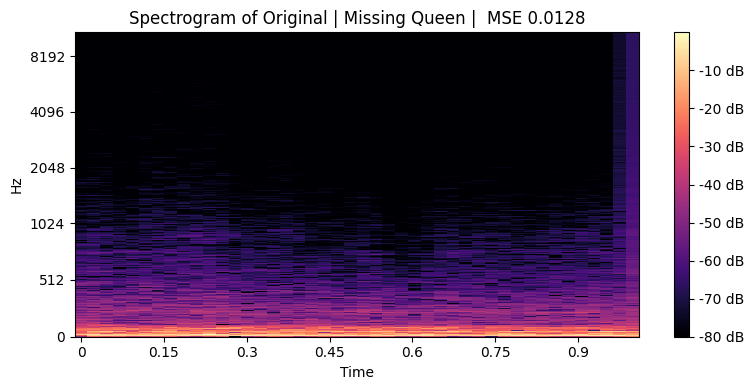

In [125]:
# Load the best model
best_model_path = 'audio_autoencoder-epoch=79-val_loss=0.00.ckpt'
best_model = AudioAutoencoder.load_from_checkpoint(f'checkpoints/{best_model_path}', feature_type=FEATURE_TYPE)

# Determine threshold (you might want to use a validation set for this)
threshold = 0.01  # This is just an example, you should determine this based on your data

device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
print(device)
# Detect anomalies
anomalies, reconstructions, originals, file_paths, mses = detect_anomalies(best_model, test_loader, threshold, device)
print(f"Detected {sum(anomalies)} anomalies out of {len(anomalies)} samples.")

# Plot spectrograms for anomalies
plot_anomalies(anomalies, reconstructions, originals, file_paths, mses)

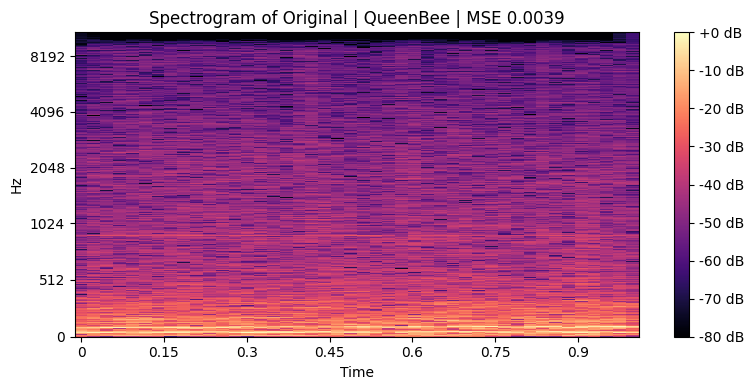

In [127]:
plot_reference(anomalies, reconstructions, originals, file_paths, mses)